#  Spectroscopic measurements data - Soil organic matter content (SOM) prediction
**Objectives:**

1.   Familiarize with the dataset (inspect and clean data).
2.   Compare the estimates **SOM** with the corresponding data
 from POLARIS soil database (Identify, Download, and ExtractPOLARIS data).
3.   Build two models and Evaluate their performance (using the sensor readings and
lab values) to predict **SOM** of closeby fields. 
**Data:**
1. [STENON challege data](https://drive.google.com/file/d/1wHEEg3O9Cjj3cj77j55egPDbJuiOHDBj/view?usp=sharing)
2. [The POLARIS soil database](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/)

In [ ]:
# Install the Python package to view the map on google maps
!pip install geemap --quiet

# Install the Python package to created to manipulate data geo-vector data
!pip install geopandas --quiet

# Install the Python package to plot charts
!pip install matplotlib==3.1.1 --quiet

In [3]:
# Standard library imports
import argparse
import logging
import sys
import os

In [56]:
# Third party imports
import pandas as pd
import numpy as np
import folium
import json
from shapely.geometry import shape, GeometryCollection
import ee
import geemap
import geopandas as gpd
from google.colab import files
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import math

# Third party imports to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

import seaborn as sns

# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.disable_dataframe_formatter()
data_table.DataTable.max_columns = 30

# Enable vertical scrolling in code block/output block
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Soil Organic Matter (SOM) prediction using linear regression

## 1.1 Objectives
* Use attributes ( spectroscopic measurements) with numeric values and linear regression for prediction

## 1.2. Data overview

### Data

In [10]:
uploaded = files.upload()

Saving data.csv to data.csv


In [119]:
def csv_valid(infile, arbitrary_number=2048):
  #arbitrary_number is an entirely arbitrary number. It just needs to be big enough to read in at least two or three CSV rows. 
  with open(infile, 'rb') as csvfile:
    try:
      sniffer = csv.Sniffer()
      dialect = sniffer.sniff(csvfile.read(arbitrary_number))
      # Perform various checks on the dialect (e.g., lineseparator, delimiter) to make sure it's sane
      delimiter = dialect.delimiter
      lineseparator = dialect.lineterminator
      # Reset the read position back to the start of the file before reading any entries.
      csvfile.seek(0)

      # Perform header check to make sure it's sane
      has_header = sniffer.has_header(csvfile.read(arbitrary_number))
      logger.info("CSV file is OK!")

      return delimiter, lineseparator, has_header
    except csv.Error:
      # File appears not to be in CSV format; move along
      logger.error ("Invalid CSV file")
      return None

In [39]:
st_path = "./data.csv"

# delimiter, _, _ = csv_valid(st_path)

if os.path.exists(st_path):
  df_data = pd.read_csv(st_path, sep=';', index_col=0)
  print(df_data.info)
else:
  print ("{} does not exists. The following code blocks won't be execused. Please check!".format(st_path))

<bound method DataFrame.info of                                  lat_lng location        som  nir_1370  \
measurement_ID                                                           
0               (41.2799111,-92.0301512)  field_A   2.038524  0.268311   
1               (41.2798524,-92.0294544)  field_A  17.443334  0.411358   
2               (41.2798545,-92.0294499)  field_A   2.227260  0.402013   
3                (41.2796759,-92.027938)  field_A   2.369437  0.506582   
4                (41.2796802,-92.027932)  field_A   2.345968  0.475707   
...                                  ...      ...        ...       ...   
1068            (41.2718012,-92.0390603)  field_B   1.919485  0.421228   
1069            (41.2717968,-92.0390726)  field_B   1.702884  0.451167   
1070            (41.2717812,-92.0374845)  field_B   1.555839  0.489369   
1071            (41.2717374,-92.0375016)  field_B   1.644490  0.507497   
1072            (41.2717458,-92.0374918)  field_B   1.591437  0.447848   

     

In [20]:
print(df_data.head(2))

                                 lat_lng location        som  nir_1370  \
measurement_ID                                                           
0               (41.2799111,-92.0301512)  field_A   2.038524  0.268311   
1               (41.2798524,-92.0294544)  field_A  17.443334  0.411358   

                nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  nir_1394  \
measurement_ID                                                               
0               0.266145  0.262247  0.256983  0.250741  0.243620  0.235660   
1               0.407535  0.401783  0.393936  0.384204  0.372926  0.360293   

                ...  nir_2486  nir_2490  nir_2494  nir_2498  nir_2502  \
measurement_ID  ...                                                     
0               ...  0.122705  0.121610  0.120648  0.119822  0.119134   
1               ...  0.165669  0.164012  0.162577  0.161365  0.160374   

                nir_2506  nir_2510  nir_2514  nir_2518  nir_2522  
measurement_ID                

In [21]:
print(df_data.tail(2))

                                 lat_lng location       som  nir_1370  \
measurement_ID                                                          
1071            (41.2717374,-92.0375016)  field_B  1.644490  0.507497   
1072            (41.2717458,-92.0374918)  field_B  1.591437  0.447848   

                nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  nir_1394  \
measurement_ID                                                               
1071            0.503908  0.497956  0.488233  0.475167  0.459762  0.442656   
1072            0.444600  0.439651  0.431790  0.421130  0.408224  0.393567   

                ...  nir_2486  nir_2490  nir_2494  nir_2498  nir_2502  \
measurement_ID  ...                                                     
1071            ...  0.172855  0.170890  0.169130  0.167590  0.166287   
1072            ...  0.165309  0.163435  0.161741  0.160241  0.158948   

                nir_2506  nir_2510  nir_2514  nir_2518  nir_2522  
measurement_ID                    

In [24]:
df_data.describe()

som     nir_1370     nir_1374     nir_1378     nir_1382  \
count  1071.000000  1073.000000  1073.000000  1073.000000  1072.000000   
mean      2.229820     0.447966     0.444705     0.439789     0.432199   
std       0.720085     0.081036     0.080482     0.079648     0.078354   
min       1.146822     0.114487     0.114780     0.114832     0.113912   
25%       1.864802     0.417341     0.414102     0.409172     0.402044   
50%       2.127110     0.461385     0.457803     0.452487     0.444243   
75%       2.411847     0.496091     0.492194     0.486352     0.477705   
max      17.443334     0.722441     0.718165     0.711620     0.700936   

          nir_1386     nir_1390     nir_1394     nir_1398     nir_1402  ...  \
count  1073.000000  1072.000000  1073.000000  1073.000000  1073.000000  ...   
mean      0.421409     0.408327     0.393682     0.377905     0.361740  ...   
std       0.076481     0.074241     0.071708     0.069052     0.066324  ...   
min       0.111786     0.108984     0.106092     0.103083     0.099624  ...   
25%       0.391879     0.378550     0.365659     0.350714     0.334423  ...   
50%       0.432546     0.418822     0.402933     0.385649     0.368380  ...   
75%       0.465522     0.451310     0.435061     0.418003     0.400395  ...   
max       0.686183     0.668080     0.647280     0.631115     0.615886  ...   

          nir_2486     nir_2490     nir_2494     nir_2498     nir_2502  \
count  1073.000000  1073.000000  1072.000000  1073.000000  1073.000000   
mean      0.174012     0.172116     0.170443     0.168944     0.167696   
std       0.034241     0.033881     0.033547     0.033221     0.032933   
min       0.040231     0.039920     0.039655     0.039435     0.039256   
25%       0.151034     0.149306     0.147870     0.146755     0.145808   
50%       0.172747     0.170898     0.169273     0.167730     0.166661   
75%       0.193789     0.191732     0.190121     0.188448     0.186827   
max       0.376515     0.373556     0.370982     0.368816     0.367055   

          nir_2506     nir_2510     nir_2514     nir_2518     nir_2522  
count  1073.000000  1073.000000  1073.000000  1073.000000  1073.000000  
mean      0.166688     0.165929     0.165429     0.165200     0.165248  
std       0.032679     0.032466     0.032299     0.032183     0.032121  
min       0.039113     0.039001     0.038915     0.038851     0.038803  
25%       0.144741     0.144004     0.143575     0.143463     0.143510  
50%       0.165694     0.164924     0.164483     0.164273     0.164455  
75%       0.185822     0.184974     0.184316     0.183966     0.183918  
max       0.365696     0.364736     0.364173     0.364004     0.364226  

[8 rows x 290 columns]

In [22]:
data_table.DataTable(df_data, include_index=False, num_rows_per_page=10)

In [10]:
# data_table.DataTable(df_data.filter(regex='nir_').describe(), include_index=False, num_rows_per_page=10)

### Inspect the input data and do primary data cleanning (Identify and drop missing/incomplete record(s)) 

In [25]:
# Count number of Rows having NaN or Empty element(s)
nrows_having_NaN = df_data.shape[0] - df_data.dropna().shape[0]
print ("Total number of Rows contain NaN or Empty element(s): {}".format(nrows_having_NaN))

Total number of Rows contain NaN or Empty element(s): 21


In [26]:
nrows_index_having_NaN = df_data.index[df_data.isnull().any(axis=1)]
print ("Following Rows: {} having NaN or Empty element(s)".format(nrows_index_having_NaN.tolist()))

Following Rows: [6, 7, 12, 148, 380, 410, 459, 548, 549, 605, 817, 827, 942, 943, 956, 1039, 1042, 1056, 1059, 1063, 1068] having NaN or Empty element(s)


In [28]:
# Count number of Rows having  all element are NaN or Empty
nrows_all_NaN = df_data.shape[0] - df_data.isnull().all(axis=1).shape[0] 
print ("Total number of Rows having  all elements are NaN or Empty: {}".format(nrows_all_NaN))

if nrows_all_NaN> 0:
    print (df_data.loc[nrows_all_NaN])
    df_data = df_data.loc[df_data.index.drop(nrows_all_NaN)]

Total number of Rows having  all elements are NaN or Empty: 0


In [67]:
# Drop Rows with missing values or NaN
df_data = df_data.dropna()

# Extract wave length
wave_length = [int(item.split('_')[1]) for item in df_data.columns.tolist() if 'nir_' in item]
print (wave_lengh)

ioc_name = [col for col in df_data.columns if (("nir_" in col) and (df_data[col].dtype == "float64"))]
print (ioc_name)

[1370, 1374, 1378, 1382, 1386, 1390, 1394, 1398, 1402, 1406, 1410, 1414, 1418, 1422, 1426, 1430, 1434, 1438, 1442, 1446, 1450, 1454, 1458, 1462, 1466, 1470, 1474, 1478, 1482, 1486, 1490, 1494, 1498, 1502, 1506, 1510, 1514, 1518, 1522, 1526, 1530, 1534, 1538, 1542, 1546, 1550, 1554, 1558, 1562, 1566, 1570, 1574, 1578, 1582, 1586, 1590, 1594, 1598, 1602, 1606, 1610, 1614, 1618, 1622, 1626, 1630, 1634, 1638, 1642, 1646, 1650, 1654, 1658, 1662, 1666, 1670, 1674, 1678, 1682, 1686, 1690, 1694, 1698, 1702, 1706, 1710, 1714, 1718, 1722, 1726, 1730, 1734, 1738, 1742, 1746, 1750, 1754, 1758, 1762, 1766, 1770, 1774, 1778, 1782, 1786, 1790, 1794, 1798, 1802, 1806, 1810, 1814, 1818, 1822, 1826, 1830, 1834, 1838, 1842, 1846, 1850, 1854, 1858, 1862, 1866, 1870, 1874, 1878, 1882, 1886, 1890, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1934, 1938, 1942, 1946, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022, 2026, 2030, 203

No handles with labels found to put in legend.
No handles with labels found to put in legend.


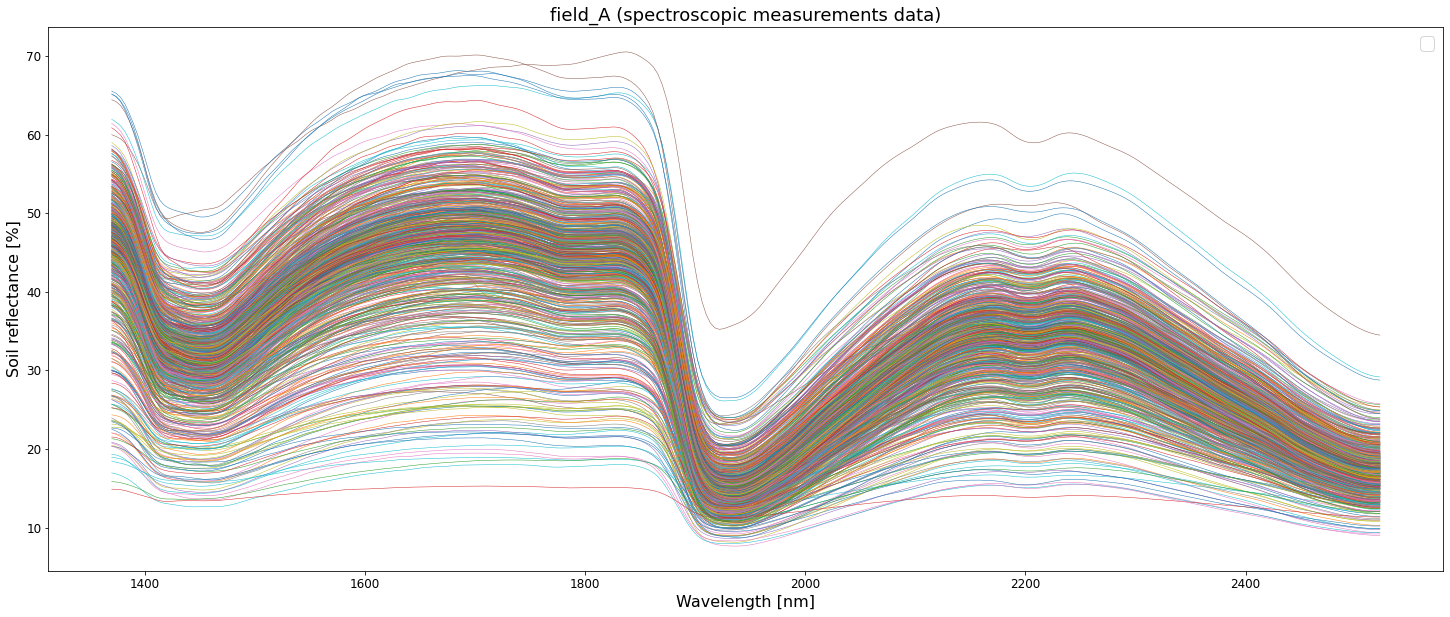

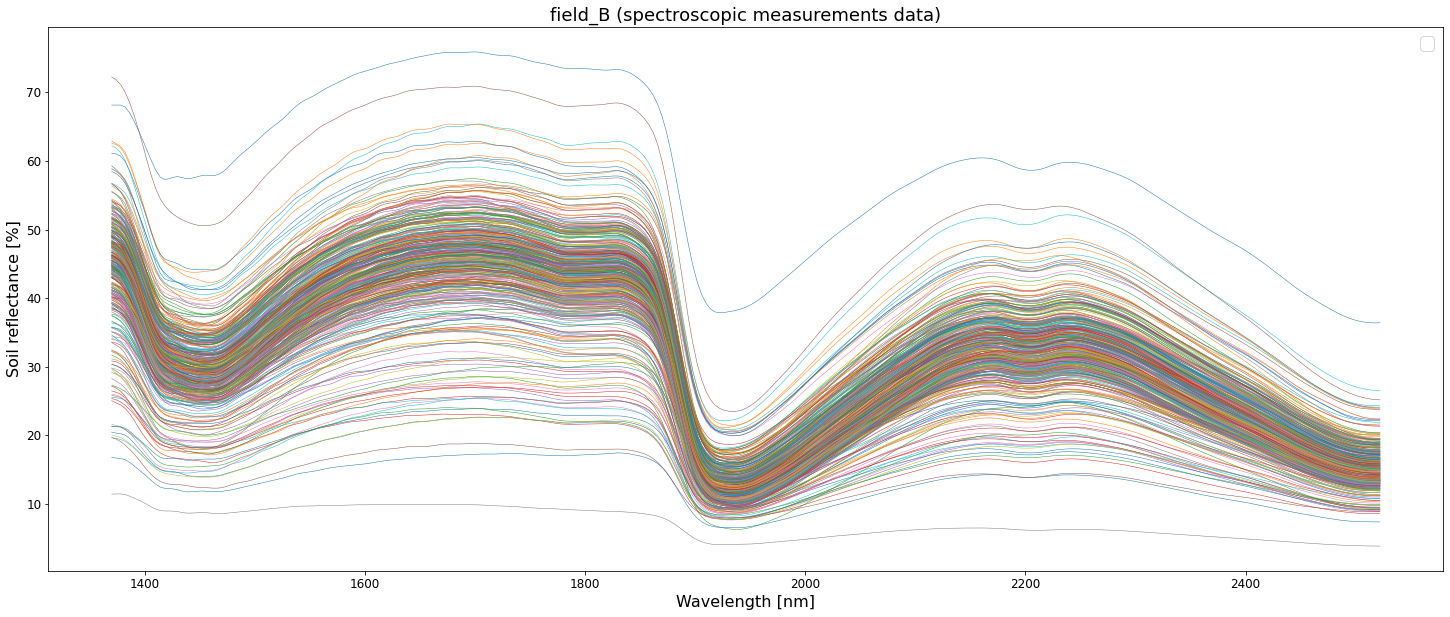

In [40]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  df_field_nir = df_field.filter(regex='nir_')
  plt.figure(figsize=(25, 10))
  plt.clf

  for _, row in df_field_nir.iterrows():
      plt.plot(wave_length, 100*row, linewidth=0.5)

  plt.xlabel("Wavelength [nm]", fontsize=16)
  plt.ylabel("Soil reflectance [%]", fontsize=16)
  plt.title ("{} (spectroscopic measurements data)".format(location_name), fontsize=18)
  plt.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


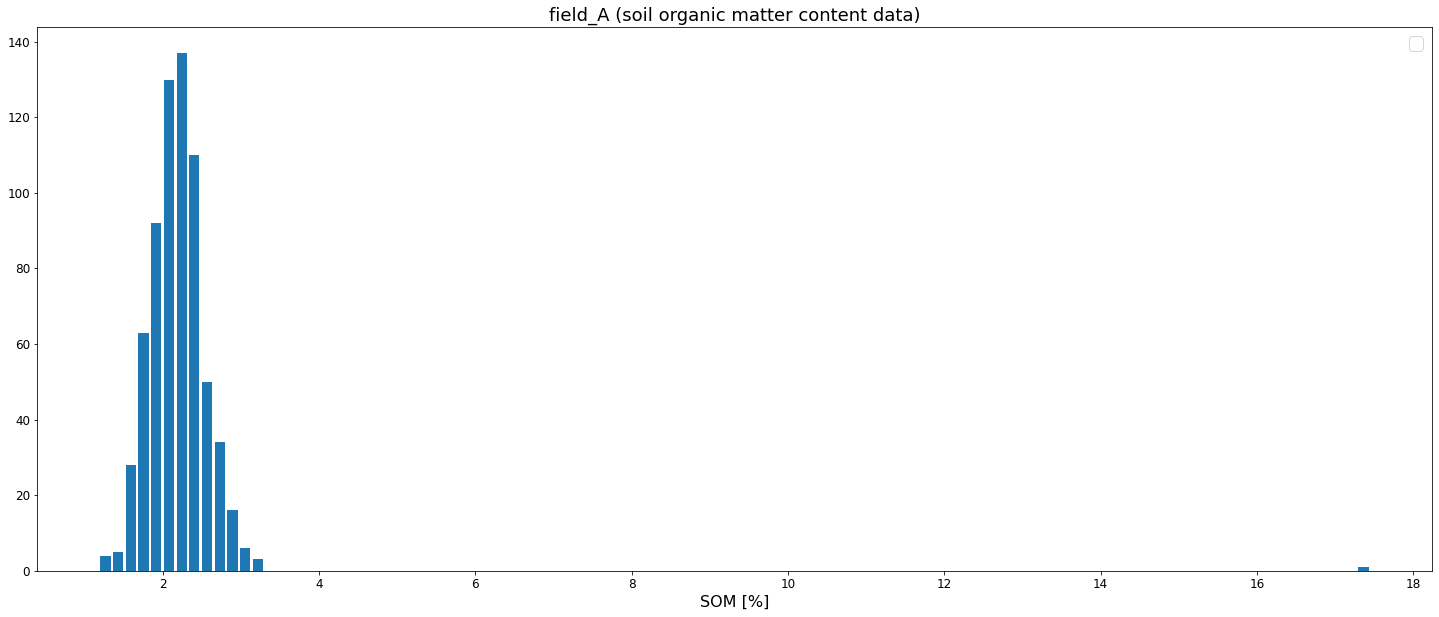

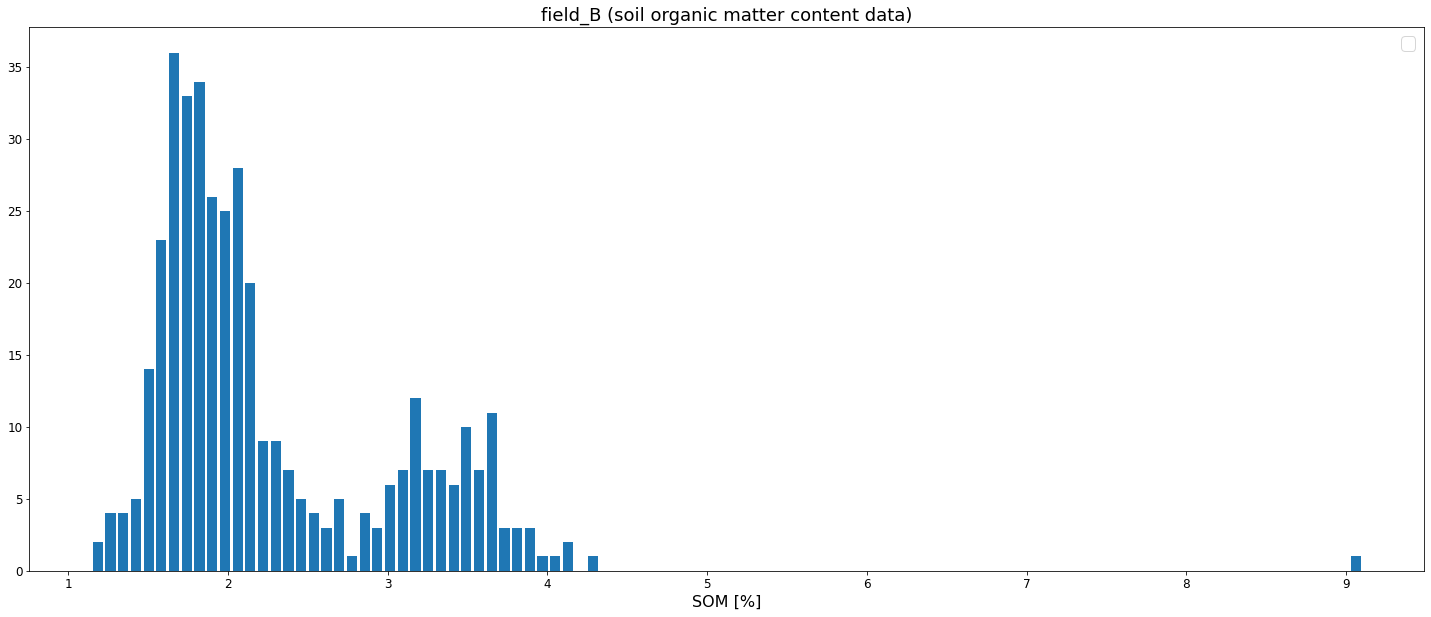

In [41]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  plt.figure(figsize=(25, 10))
  plt.clf

  plt.hist(df_field['som'], bins=100, histtype='bar', rwidth=0.8)
  plt.xlabel("SOM [%]", fontsize=16)
  plt.title ("{} (soil organic matter content data)".format(location_name), fontsize=18)
  plt.legend()

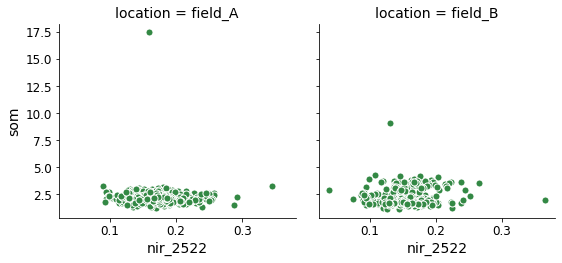

In [70]:
g = sns.FacetGrid(df_data, col="location", margin_titles=True, height=4)
g.map(plt.scatter, "nir_2522", "som", color="#338844", edgecolor="white", s=50, lw=1)

In [15]:
# sns.lmplot('nir_1370', 'nir_2522', data=df_data, fit_reg=True)

In [72]:
def density_scatter(df, field_name, xcol='nir_2522', ycol='som', ax = None, sort=True, bins=20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """

    x = df_field[xcol].to_numpy()
    y = df_field[ycol].to_numpy()

    if ax is None :
        fig , ax = plt.subplots(figsize=(10, 8))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    plt.xlabel('Sum_of_Soil_sample_Reflectance_diff', fontsize=16)
    plt.ylabel('SOM_diff [%]', fontsize=16)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize=18)
    ax.set_title ("{} (Original clean data)".format(field_name), fontsize=18)
    plt.show()

    return ax

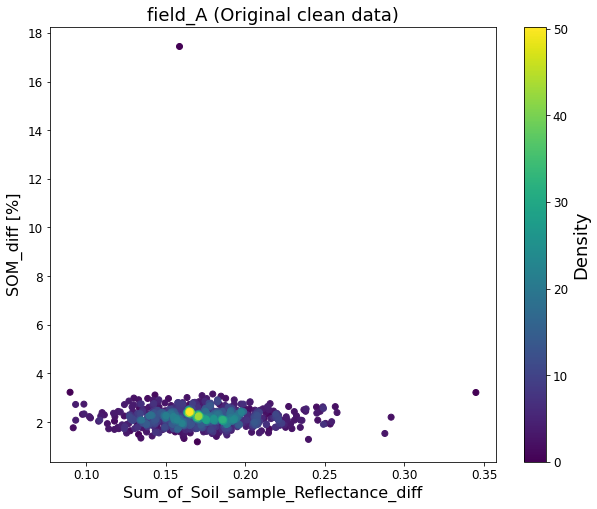

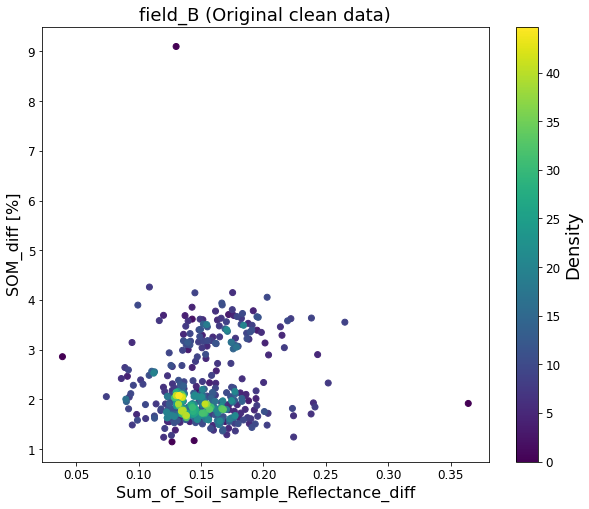

In [74]:
for location_name in set(df_data['location'].tolist()):
  df_field = df_data[df_data['location'] == location_name]
  density_scatter(df_field, location_name, xcol='nir_2522', ycol='som', bins=[100,100])

In [75]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)


# Conver pandas dataframe into geojson format
def pandas_to_geojson(
    df,
    out_geojson=None,
    latitude_longitude="lat_lng",
    encoding="utf-8",
):
    """Creates points for a Pandas DataFrame and exports data as a GeoJSON.

    Args:
        df (pandas.DataFrame): The input Pandas DataFrame.
        out_geojson (str): The file path to the exported GeoJSON. Default to None.
        latitude (str, optional): The name of the column containing latitude coordinates. Defaults to "latitude".
        longitude (str, optional): The name of the column containing longitude coordinates. Defaults to "longitude".
        encoding (str, optional): The encoding of characters. Defaults to "utf-8".

    """

    # import json
    from geojson import Feature, FeatureCollection, Point

    if out_geojson is not None:
        out_dir = os.path.dirname(os.path.abspath(out_geojson))
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

    features = df.apply(
        lambda row: Feature(
            geometry=Point((float(row['lat_lng'][1:-1].split(',')[1]), float(row['lat_lng'][1:-1].split(',')[0]))),
            properties=dict(row),
        ),
        axis=1,
    ).tolist()

    geojson = FeatureCollection(features=features)

    if out_geojson is None:
        return geojson
    else:
        with open(out_geojson, "w", encoding=encoding) as f:
            f.write(json.dumps(geojson))

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [76]:
geojson = pandas_to_geojson(df_data.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson)

Map = geemap.Map(center=(20, 0), zoom=3.5, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Handling missing and outlier data

* Identify and drop wrong (geo-location) record(s) from data.
* Identify missing and outlier data and update it with mean for the columns containing numeric values.  

In [111]:
df_data_correct_geo = df_data[df_data['lat_lng'] != '(0,0)']

geojson = pandas_to_geojson(df_data_correct_geo.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson)

Map = geemap.Map(center=(20, 0), zoom=3.5, lite_mode=True, add_google_map=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [116]:
_temp_geo = df_data_correct_geo["lat_lng"].str.slice(start=1,stop=-1).str.split(",", n = 1, expand = True)
df_data_correct_geo["lat"] = _temp_geo[0]
df_data_correct_geo['lng'] = _temp_geo[1]
df_data_correct_geo[["lat", "lng"]] = df_data_correct_geo[["lat", "lng"]].apply(pd.to_numeric)
lat_mean = df_data_correct_geo["lat"].mean()
lon_mean = df_data_correct_geo["lng"].mean()

In [114]:
geojson = pandas_to_geojson(df_data_correct_geo.iloc[:, :4])
fc = geemap.geojson_to_ee(geojson)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [112]:
geojson = pandas_to_geojson(df_data_correct_geo.iloc[:, :4][df_data_correct_geo['location']== 'field_A'])
fc = geemap.geojson_to_ee(geojson)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [113]:
geojson = pandas_to_geojson(df_data_correct_geo.iloc[:, :4][df_data_correct_geo['location']== 'field_B'])
fc = geemap.geojson_to_ee(geojson)

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=15, lite_mode=True)
Map.addLayer(fc, {}, 'csv to ee 2')
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [117]:
# states = ee.FeatureCollection("TIGER/2018/States")
# style = {'color': 'black', 'fillColor': "00000000"}
# Map.addLayer(states.style(**style), {}, "US States")

Map.remove_labels()

Map = geemap.Map(center=(lat_mean, lon_mean), zoom=16, lite_mode=True, add_google_map=True)

# Labeling a Pandas DataFrame
Map.add_labels(
    df_data_correct_geo[['location', 'lat', 'lng', 'som']],
    "location",
    x='lng',
    y='lat',
    font_size="16pt",
    font_color="red",
    font_family="arial",
    # font_weight="bold",
)
Map

Map(center=[41.274012063748785, -92.03210487497618], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Relationship between input features and target variable

1.   List item
2.   List item

In [ ]:
def compute_rows_pair_pandas_dataframe_different(df, cols=[]):
  import sys

  if cols:
    df = df[cols]
  if len(df.shape) == 1:
    df["_"] = 0
  elif len(df.shape) > 1:
    df = df
  else:
    print ('dataframe is invalid')
    sys.exit()

  arr = df.to_numpy()
  # import pdb; pdb.set_trace()
  arr_euclidean = pdist(arr, metric='euclidean')
  # arr_euclidean_square = squareform(arr_euclidean)

  df.drop("_", axis=1, inplace=True, errors='ignore')

  return arr_euclidean

In [ ]:
def density_scatter( x , y, field_name, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(15, 10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    plt.xlabel('Sum_of_Soil_sample_Reflectance_diff', fontsize=16)
    plt.ylabel('SOM_diff [%]', fontsize=16)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density', fontsize=18)
    ax.set_title ("{} (Original clean data)".format(field_name), fontsize=18)
    plt.show()

    # return ax


In [ ]:
# https://stackoverflow.com/questions/42116801/1d-vector-from-lower-part-of-diagonal-in-matrix-python
# https://stackoverflow.com/questions/42885239/correlation-matrix-of-two-pandas-dataframe-with-p-values
# https://camnangbep.com/cach-tinh-p-value-trong-kinh-te-luong-1637762985/

def compute_data_correlation(df, p_value_thresold=0.00001):
  df_T = pd.DataFrame(df.transpose())

  coeffmat = np.zeros((df_T.shape[1], df_T.shape[1]))
  pvalmat = np.zeros((df_T.shape[1], df_T.shape[1]))

  for i in range(df_T.shape[1]):    
      for j in range(df_T.shape[1]):        
          corrtest = pearsonr(df_T[df_T.columns[i]], df_T[df_T.columns[j]])  

          coeffmat[i,j] = corrtest[0]
          pvalmat[i,j] = corrtest[1]

  dfcoeff = pd.DataFrame(coeffmat, columns=df_T.columns, index=df_T.columns)
  dfpvals = pd.DataFrame(pvalmat, columns=df_T.columns, index=df_T.columns)

  dfcoeff_arr = dfcoeff.to_numpy()
  dfpvals_arr = dfpvals.to_numpy()

  dfcoeff_arr[dfpvals_arr > p_value_thresold] = 0

  # Lay tat ca cac so hang tren duong cheo chinh
  dfcoeff_arr_tril = dfcoeff_arr[np.tril_indices(n = dfcoeff_arr.shape[0], m = dfcoeff_arr.shape[1])]

  return dfcoeff_arr, dfcoeff_arr_tril

In [ ]:
# https://tienichnho.com/to-hop-chap
def compute_spectral_similarity(df):
  """TODO"""
  X = df.to_numpy()
  m, n = X.shape
  n_factorial = math.factorial(m)/(math.factorial(m-2)*2)

  out_result = np.empty((0, n), float)

  k = 0
  for i in range(0, m - 1):
      for j in range(i + 1, m):
          # out_result = np.append(out_result, np.array([(X[i] - X[j])**2]), axis=0)
          out_result = np.append(out_result, np.array([np.sqrt((X[i] - X[j])**2)]), axis=0)

  masked_data = np.ma.masked_where(out_result == 0, out_result)

  mdata=np.ma.masked_where(out_result == 0,out_result)
  masked_data=np.ma.filled(mdata, 0)

  maximums_columns = np.max(masked_data, axis=0)
  minimums_columns = np.min(masked_data, axis=0)
  mean_columns = np.mean(masked_data, axis=0)
  median_columns = np.median(masked_data, axis=0)
  p97_5 = np.percentile(masked_data, 97.5, axis=0)
  p2_5 = np.percentile(masked_data, 2.5, axis=0)
  stdev = np.std(masked_data, axis=0)

  parms = [median_columns, minimums_columns, maximums_columns, stdev, p97_5, stdev]

  return parms

In [ ]:
  in_csv = "/content/drive/MyDrive/JOB_GIANGTRAN/STENON/challenge_geo/output/clean_data/data_clean_with_group_by_location.csv"

  challenge_geo_df = pd.read_csv(in_csv, sep=',')
  # Count number of Rows having NaN
  challenge_geo_df.shape[0] - challenge_geo_df.dropna().shape[0]

  # Identify Rows with NaN values
  challenge_geo_df.loc[challenge_geo_df.isnull().any(axis=1)]

  # Drop Rows with missing values or NaN
  df = challenge_geo_df.dropna()
  wave_lengh = [int(item.split('_')[1]) for item in df.columns.tolist() if 'nir_' in item]

# **Original data after Clean**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name]
  nir_arr = compute_rows_pair_pandas_dataframe_different(df_field.filter(regex='nir_'))
  som_arr = compute_rows_pair_pandas_dataframe_different(df_field, cols=['som'])
  density_scatter(nir_arr, som_arr, location_name, bins = [100,100])

# **Original data after Clean and Group**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  nir_arr = compute_rows_pair_pandas_dataframe_different(df_field.filter(regex='nir_'))
  som_arr = compute_rows_pair_pandas_dataframe_different(df_field, cols=['som'])

  location_name = location_name + "_Group"
  density_scatter(nir_arr, som_arr, location_name, bins = [100,100])

# **Original data after Clean (correlation check)**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name]
  df_field_nir = df_field.filter(regex='nir_')
  dfcoeff_arr, dfcoeff_arr_tril = compute_data_correlation(df_field_nir)

  # Prepare image and figure
  plt.clf
  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(40,10))
  ax1.hist(dfcoeff_arr_tril[(dfcoeff_arr_tril !=1) & (dfcoeff_arr_tril!=0)], bins='auto')
  ax2.imshow(dfcoeff_arr, cmap=cm.gray)
  plt.title ("{} (Original clean data)".format(location_name), fontsize=18)

# **Original data after Clean and Group (correlation check)**

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  df_field_nir = df_field.filter(regex='nir_')
  dfcoeff_arr, dfcoeff_arr_tril = compute_data_correlation(df_field_nir)

  # Prepare image and figure
  plt.clf
  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(40,10))
  ax1.hist(dfcoeff_arr_tril[(dfcoeff_arr_tril !=1) & (dfcoeff_arr_tril!=0)], bins='auto')
  ax2.imshow(dfcoeff_arr, cmap=cm.gray)
  plt.title ("{} (Clean ad Group data)".format(location_name), fontsize=18)

In [ ]:
for location_name in set(df['location'].tolist()):
  df_field = df[df['location'] == location_name].groupby(['group']).median() # Compute means
  df_field_nir = df_field.filter(regex='nir_')

  params = compute_spectral_similarity(df_field_nir)

  plt.figure(figsize=(25, 10))
  plt.clf

  for _, row in df_field_nir.iterrows():
      plt.plot(wave_lengh, row, linewidth=0.1)

  plt.plot(wave_lengh, params[0], label='median', linewidth=3.0, color='green')
  plt.plot(wave_lengh, params[1], label='minimum', linewidth=3.0, color='red')
  plt.plot(wave_lengh, params[2], label='maximum', linewidth=3.0, color='blue')
  plt.plot(wave_lengh, params[3], label='p97.5', linewidth=3.0, color='yellow')
  plt.xlabel("Wavelength [nm]", fontsize=16)
  plt.ylabel("Soil reflectance different", fontsize=16)
  plt.title ("{} (Clean ad Group data)".format(location_name), fontsize=18)
  plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.clf
for index, row in features_B_1.iterrows():
    som = mean_df_B.iloc[[index]]['som'].values
    if index == 14:
      plt.plot(wave_lengh, row, linewidth=3.0, color='blue', label='OM_max = %0.2f'%som)
    elif index == 43:
      plt.plot(wave_lengh, row, linewidth=3.0, color='red', label='OM_min = %0.2f'%som)
    else:
      plt.plot(wave_lengh, row, linewidth=0.1)

plt.legend(fontsize=16)
plt.grid()

mean_df_B.loc[mean_df_B['som'].idxmax()]
index = mean_df_B.som.argmin()
print (index)

In [ ]:
plt.figure(figsize=(25, 10))
plt.clf
for index, row in features_B.iterrows():
    # print (index)
    som = df_B.iloc[[index]]['som'].values
    if index == 109:
      plt.plot(wave_lengh, row, linewidth=3.0, color='blue', label='OM_max = %0.2f'%som)
    elif index == 330:
      plt.plot(wave_lengh, row, linewidth=3.0, color='red', label='OM_min = %0.2f'%som)
    else:
      plt.plot(wave_lengh, row, linewidth=0.1)

plt.legend(fontsize=16)
plt.grid()

# selecting rows based on condition
# rslt_df = dataframe[dataframe['Percentage'] > 80]

index = df_B.som.argmin()
print (index)

In [118]:
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
import logging as logger
import matplotlib.pyplot as plt


def csv_valid(infile, arbitrary_number=2048):
    #arbitrary_number is an entirely arbitrary number. It just needs to be big enough to read in at least two or three CSV rows. 
    with open(infile, 'rb') as csvfile:
        try:
            sniffer = csv.Sniffer()
            dialect = sniffer.sniff(csvfile.read(arbitrary_number))
            # Perform various checks on the dialect (e.g., lineseparator, delimiter) to make sure it's sane
            delimiter = dialect.delimiter
            lineseparator = dialect.lineterminator
            # Reset the read position back to the start of the file before reading any entries.
            csvfile.seek(0)

            # Perform header check to make sure it's sane
            has_header = sniffer.has_header(csvfile.read(arbitrary_number))
            logger.info("CSV file is OK!")

            return delimiter, lineseparator, has_header
        except csv.Error:
            # File appears not to be in CSV format; move along
            logger.error ("Invalid CSV file")
            return None
    
# read in the San Francisco building permits data
infile = "/content/drive/MyDrive/JOB_GIANGTRAN/STENON/challenge_geoDS.csv"

# delimiter, _, _ = csv_valid(infile)

challenge_geo_df = pd.read_csv(infile, sep=';')

# Count number of Rows having NaN
challenge_geo_df.shape[0] - challenge_geo_df.dropna().shape[0]

# Identify Rows with NaN values
challenge_geo_df.loc[challenge_geo_df.isnull().any(axis=1)]

# Drop Rows with missing values or NaN
df = challenge_geo_df.dropna()

# df.head()


geojson = pandas_to_geojson(df.iloc[:100 , :10])
fc = geemap.geojson_to_ee(geojson)

FileNotFoundError: ignored